In [10]:
#  Install necessary libraries
!pip install numpy pandas matplotlib scikit-learn seaborn
!pip install yfinance tensorflow keras-tuner

In [11]:
 #Import Required Libraries
from datetime import date, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import BayesianOptimization
from matplotlib.dates import DateFormatter
from pandas.tseries.offsets import DateOffset


[*********************100%***********************]  1 of 1 completed


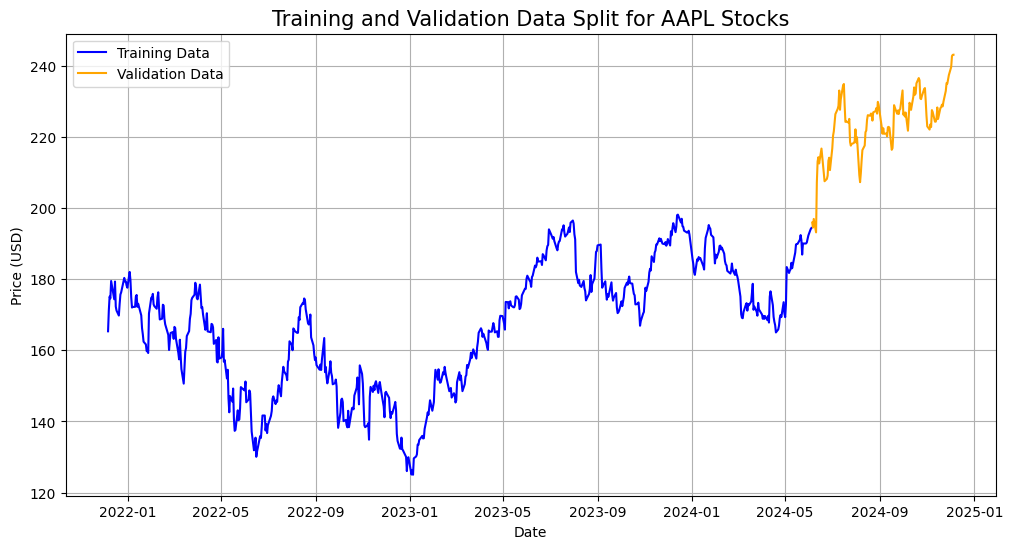

In [12]:
# Constants
TODAY = date.today().strftime("%Y-%m-%d")
START_DATE = (pd.Timestamp(TODAY) - pd.DateOffset(months=36)).strftime("%Y-%m-%d")
TICKER = "AAPL"

# Load stock data from Yahoo Finance
def fetch_stock_data(ticker):
    data = yf.download(ticker, START_DATE, TODAY)
    data.reset_index(inplace=True)
    return data

data = fetch_stock_data(TICKER)

# Split into training and testing datasets
validation_period = data['Date'].max() - DateOffset(months=6)
test = data[data['Date'] >= validation_period].copy()
train = data[data['Date'] < validation_period].copy()

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_close = train['Close'].values.reshape(-1, 1)
test_close = test['Close'].values.reshape(-1, 1)
scaled_train_data = scaler.fit_transform(train_close)

# Prepare GRU data
def prepare_data_for_gru(scaled_data, window_size=30):
    X, y = [], []
    for i in range(window_size, scaled_data.shape[0]):
        X.append(scaled_data[i - window_size:i])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y)

x_train, y_train = prepare_data_for_gru(scaled_train_data)
past_30_days = train['Close'].tail(30).values.reshape(-1, 1)
final_test_data = np.concatenate([past_30_days, test_close], axis=0)
scaled_test_data = scaler.transform(final_test_data)
x_test, y_test = prepare_data_for_gru(scaled_test_data)

# Visualize training and testing data
plt.figure(figsize=(12, 6))
plt.plot(train['Date'], train['Close'], label='Training Data', color='blue')
plt.plot(test['Date'], test['Close'], label='Validation Data', color='orange')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title(f'Training and Validation Data Split for {TICKER} Stocks', size=15)
plt.legend()
plt.grid(True)
plt.show()



In [13]:
# Define the GRU model for Bayesian Optimization
def build_gru_model(hp):
    model = Sequential()
    model.add(GRU(
        units=hp.Int('gru_units_1', min_value=50, max_value=200, step=10),
        activation='tanh',
        return_sequences=True,
        input_shape=(x_train.shape[1], 1)
    ))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(GRU(
        units=hp.Int('gru_units_2', min_value=50, max_value=150, step=10),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_units', min_value=10, max_value=100, step=10)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Initialize tuner
tuner = BayesianOptimization(
    build_gru_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='GRU_Tuning',
    project_name='GRU_Stock_Prediction'
)

# Tune model
tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 10 Complete [00h 00m 36s]
val_loss: 0.002000703476369381

Best val_loss So Far: 0.0018889487255364656
Total elapsed time: 00h 10m 54s


In [14]:
# Train the best model with early stopping
model = tuner.hypermodel.build(best_hps)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    epochs=100,
    validation_data=(x_test, y_test),
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0940 - val_loss: 0.0044
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0070 - val_loss: 0.0034
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0055 - val_loss: 0.0029
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0032 - val_loss: 0.0104
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/st

In [15]:
# Predict and rescale the values
y_pred = model.predict(x_test)
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

# Calculate metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
mae_percentage = (mae / np.mean(y_test_rescaled)) * 100

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mae_percentage:.2f}%")
print(f"R² Score: {r2:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Mean Absolute Error (MAE): 2.31
Mean Squared Error (MSE): 10.16
Mean Absolute Percentage Error (MAPE): 1.03%
R² Score: 0.88


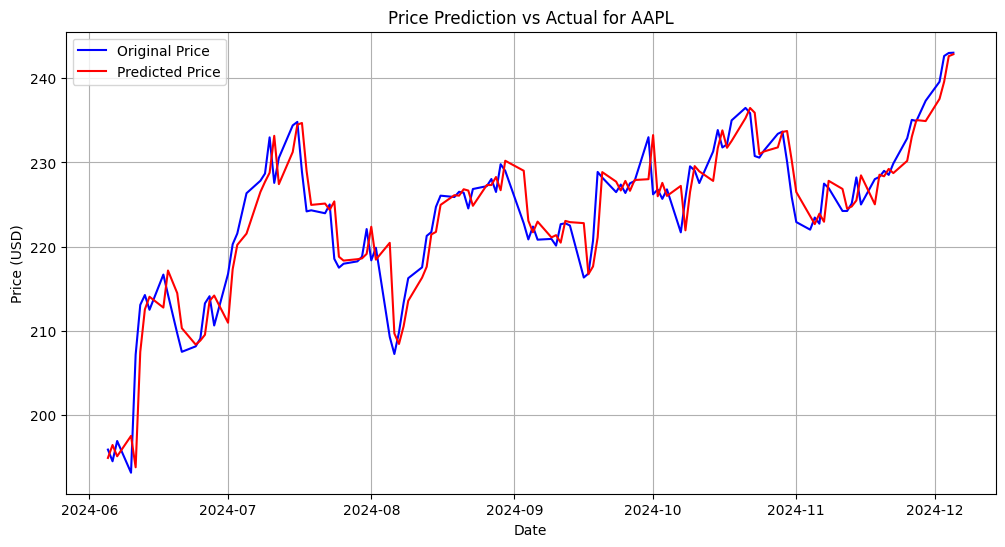

In [16]:
# Plot 1: Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], y_test_rescaled, label="Original Price", color='blue')
plt.plot(test['Date'], y_pred_rescaled[-len(test):], label="Predicted Price", color='red')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title(f'Price Prediction vs Actual for {TICKER}')
plt.legend()
plt.grid(True)
plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


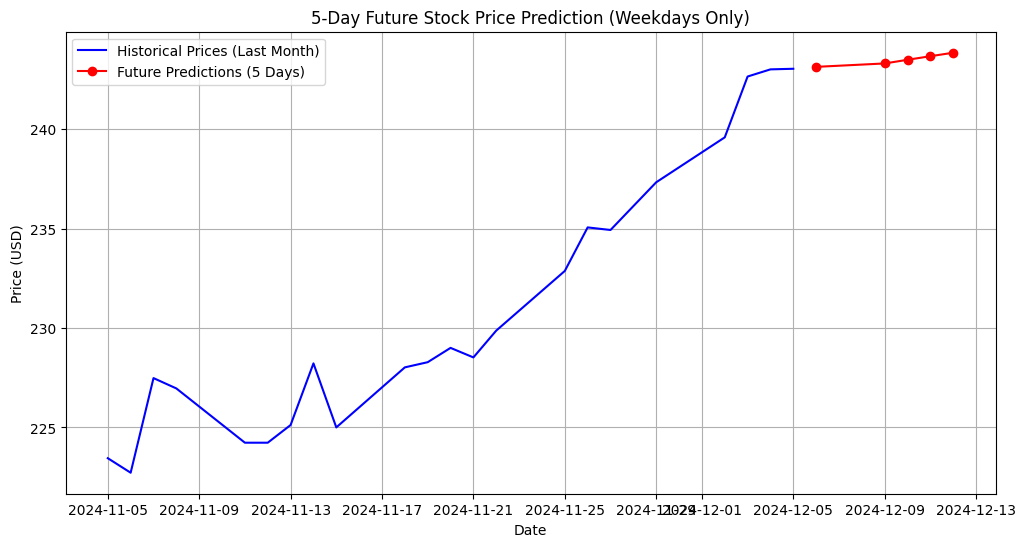

5-Day Predictions (Weekdays Only):
Predicted Price on 2024-12-06: $243.14
Predicted Price on 2024-12-09: $243.31
Predicted Price on 2024-12-10: $243.49
Predicted Price on 2024-12-11: $243.67
Predicted Price on 2024-12-12: $243.85


In [17]:
# Function to predict the next few days (e.g., 5 trading days)
def predict_future(model, last_n_days, scaler, days=5, window_size=30):
    """
    Predict future stock prices for 'days' trading days, excluding weekends.
    """
    future_predictions = []
    input_sequence = last_n_days.reshape(1, window_size, 1)
    future_dates = []
    current_date = data['Date'].max()  # Start from the last date in the dataset

    while len(future_predictions) < days:
        # Skip weekends
        current_date += timedelta(days=1)
        if current_date.weekday() in [5, 6]:  # Saturday and Sunday
            continue

        # Predict the next day
        next_day_pred = model.predict(input_sequence)[0, 0]
        future_predictions.append(next_day_pred)
        future_dates.append(current_date)

        # Update the input sequence by appending the predicted value and sliding the window
        next_day_scaled = np.append(input_sequence[0, 1:], [[next_day_pred]], axis=0)
        input_sequence = next_day_scaled.reshape(1, window_size, 1)

    # Convert predictions back to the original scale
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).reshape(-1)
    return future_dates, future_predictions



# For Graph : Last month’s historical data + 5-day predictions
last_n_days_scaled = scaler.transform(data['Close'].tail(60).values.reshape(-1, 1))
future_dates_30, future_predictions_30 = predict_future(model, last_n_days_scaled, scaler, days=5, window_size=60)

# Plot Graph : Historical data of last month + Future Predictions
plt.figure(figsize=(12, 6))
last_month_data = data[data['Date'] >= data['Date'].max() - pd.DateOffset(months=1)]
plt.plot(last_month_data['Date'], last_month_data['Close'], label="Historical Prices (Last Month)", color='blue')
plt.plot(future_dates_30, future_predictions_30, label="Future Predictions (5 Days)", color='red', marker='o')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('5-Day Future Stock Price Prediction (Weekdays Only)')
plt.legend()
plt.grid(True)
plt.show()

# Print the future predicted prices
print("5-Day Predictions (Weekdays Only):")
for date, price in zip(future_dates_30, future_predictions_30):
    print(f"Predicted Price on {date.strftime('%Y-%m-%d')}: ${price:.2f}")


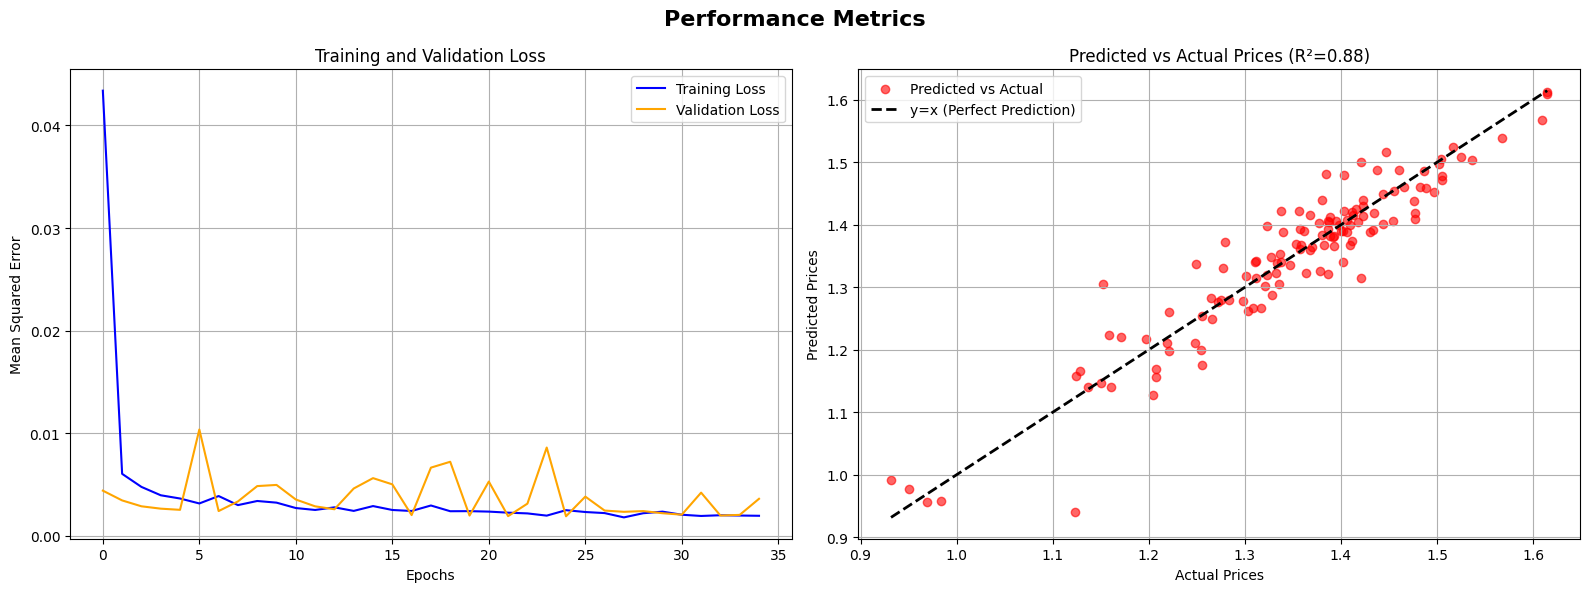

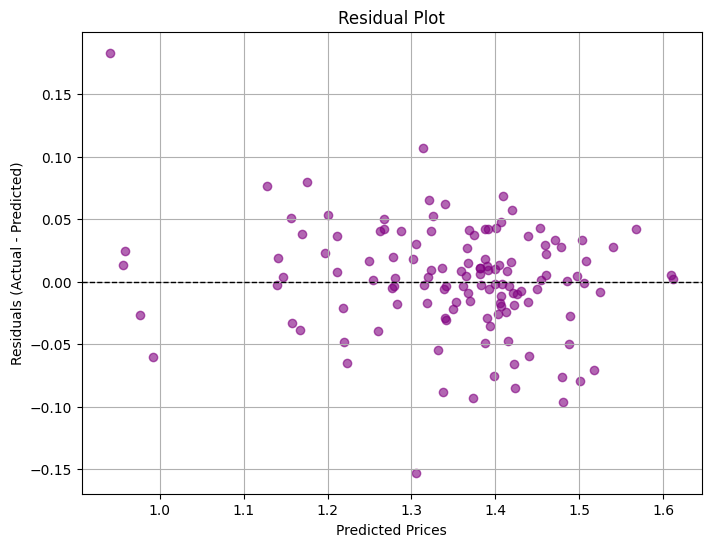

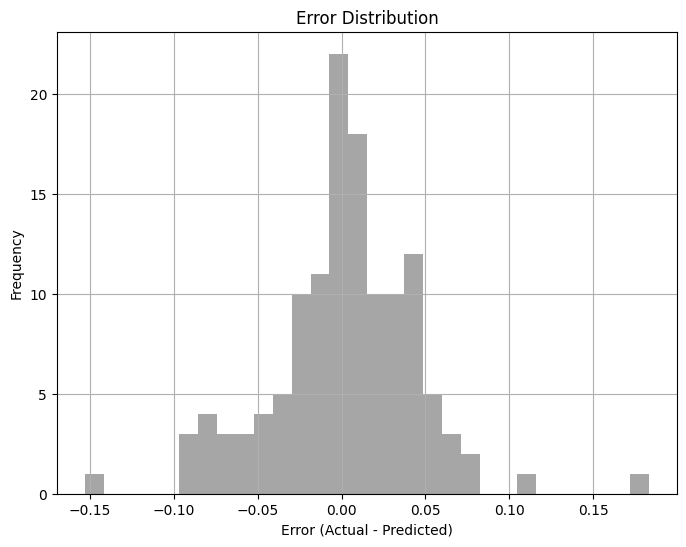

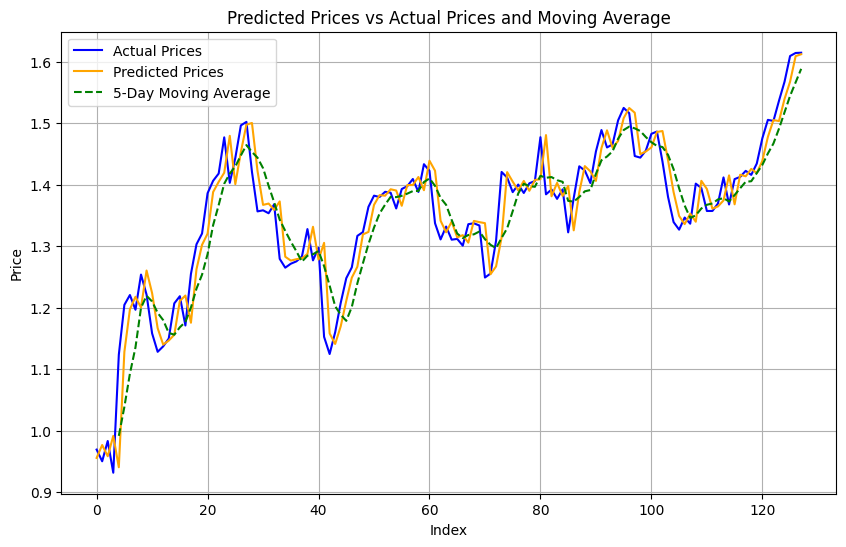


Metrics:
Mean Absolute Error (MAE): 2.31
Mean Absolute Percentage Error (MAPE): 1.03%
Symmetric Mean Absolute Percentage Error (SMAPE): 2.41%
Mean Bias Error (MBE): -0.00
Explained Variance Score: 0.88
R² Score: 0.88
Accuracy Percentage: 98.97%


In [18]:
# Reshape y_test and y_pred to 1D arrays if needed
y_test = y_test.ravel()  # Ensures 1D for compatibility
y_pred = y_pred.ravel()  # Ensures 1D for compatibility

# Create subplots for loss curves and R² scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns
fig.suptitle('Performance Metrics', fontsize=16, fontweight='bold')

# Plot 1: Training and Validation Loss
ax1.plot(history.history['loss'], label='Training Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot 2: R² Scatter Plot with Perfect Prediction Line
ax2.scatter(y_test, y_pred, alpha=0.6, color='red', label='Predicted vs Actual')

# Add y = x line for reference
ax2.plot(
    [y_test.min(), y_test.max()],  # x-coordinates of line
    [y_test.min(), y_test.max()],  # y-coordinates of line
    'k--', lw=2, label='y=x (Perfect Prediction)'  # Line style and label
)
ax2.set_xlabel('Actual Prices')
ax2.set_ylabel('Predicted Prices')
ax2.set_title(f'Predicted vs Actual Prices (R²={r2:.2f})')
ax2.legend()
ax2.grid(True)

# Display the plots
plt.tight_layout()
plt.show()

# Additional Visualization: Residual Plot
residuals = y_test - y_pred  # Calculate residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='purple')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

# Additional Visualization: Error Distribution
errors = y_test - y_pred  # Calculate prediction errors
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, color='gray', alpha=0.7)
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.grid(True)
plt.show()

# Additional Visualization: Moving Average Comparison
actual_moving_avg = pd.Series(y_test).rolling(window=5).mean()  # 5-day moving average
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='orange')
plt.plot(actual_moving_avg, label='5-Day Moving Average', color='green', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Predicted Prices vs Actual Prices and Moving Average')
plt.legend()
plt.grid(True)
plt.show()

# Additional Metrics Calculation
accuracy_percentage = 100 - mae_percentage  # Complements the MAPE
smape = 100 / len(y_test) * np.sum(2 * np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred)))  # SMAPE
mbe = np.mean(y_pred - y_test)  # Mean Bias Error
explained_variance = 1 - np.var(residuals) / np.var(y_test)  # Explained Variance Score

# Print metrics
print("\nMetrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mae_percentage:.2f}%")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}%")
print(f"Mean Bias Error (MBE): {mbe:.2f}")
print(f"Explained Variance Score: {explained_variance:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Accuracy Percentage: {accuracy_percentage:.2f}%")
